In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import config
import os, sys
config.update("jax_enable_x64", True)
import pickle
import time
from pathlib import Path
project_root = Path().resolve()              # e.g. /workspaces/TIME_DOMAIN_WORK
simphony_path = project_root / "simphony"    # relative clone folder
sys.path.insert(0, str(simphony_path))
import simphony
from scipy import signal
from simphony.utils import SPEED_OF_LIGHT
from simphony.libraries import siepic,ideal
from simphony.time_domain.ideal import Modulator
from simphony.time_domain.simulation import TimeResult, TimeSim
from simphony.time_domain.utils import gaussian_pulse, smooth_rectangular_pulse
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d


/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/sax/backends/__init__.py:58: UserWarning: klujax not found. Please install klujax for better performance during circuit evaluation!
  warnings.warn(


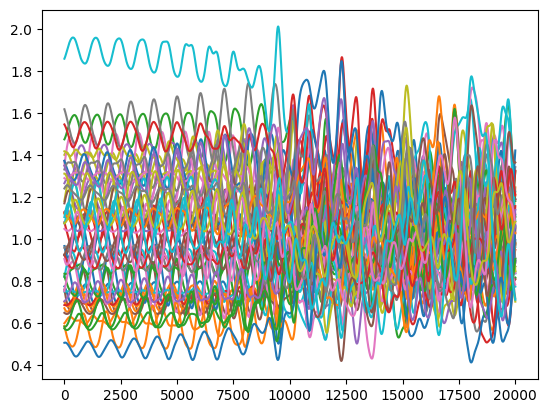

[ 0.42845142-0.768277j   -0.66122496+0.4017346j  -0.66216844+1.0179752j
  1.0370795 +0.06252519j  1.1248239 +0.01596888j -0.04372691-0.8702748j
  0.16659845-1.01021j    -0.7697493 -0.72900736j -0.9119145 -0.7546625j
 -0.8701159 -0.24900508j  0.23623373-0.9304109j  -0.36154884+0.75527716j
 -0.5696952 +0.71411955j  0.82292575+0.09019709j  1.1636347 +0.13522415j
  0.07638595-0.95997095j -0.10008772-1.1583781j  -1.1416949 -0.5608606j
 -0.956462  -0.51631105j -0.8160911 -0.28975078j  0.22716428-0.9564922j
 -0.29429835+0.7639001j  -0.4120918 +0.80773264j  1.040621  -0.21324523j
  1.0537149 -0.10418908j -0.01888384-0.80501205j  0.02857695-0.8668221j
 -0.87751395-0.4330762j  -1.0975646 -0.46170047j -1.3485303 -0.20117718j
  0.05197215-1.1704648j  -0.34899294+0.68062454j -0.36924458+0.66757584j
  0.87032574-0.40770003j  0.78895915-0.28404686j -0.36426878-1.0184427j
 -0.3503494 -1.0803505j  -1.0486447 -0.4811188j  -1.0301894 -0.49997124j
 -1.0159256 -0.20630436j -0.21926604-0.6763386j  -0.379889

In [37]:
data = np.load("X_mmi_binary_10.npz")
X_re    = data["X_re"]
X_im    = data["X_im"]
y = data["labels"]
y_data = np.asarray(y, dtype=float)
X_data    = X_re + 1j * X_im  
plt.plot(np.abs(X_data[00000:20000])**2)
plt.show()
print(X_data[0])

In [3]:
# --- Lorenz‐63 and integration setup --------------------------------
sigma, rho, beta = 10.0, 28.0, 8/3

def lorenz(t, xyz):
    x, y, z = xyz
    return [
        sigma*(y - x),
        x*(rho - z) - y,
        x*y - beta*z,
    ]

dt        = 0.05
n_train   = 400
n_test    = 601
n_warmup  = 100
total     = n_warmup + n_train + n_test   # 1101
t_eval    = np.linspace(0, dt*total, total)

# solve
sol = solve_ivp(lorenz, (0, t_eval[-1]), (0.,1.,1.05),
                t_eval=t_eval, method="RK45")
xyz = sol.y.T
x, y_, z_ = xyz.T

# normalize to [−1,1]
def minmax(u):
    return 2*(u - u.min())/(u.max() - u.min()) - 1

# coarse → fine upsampling
N_coarse = 1001
t_coarse = np.arange(N_coarse)*dt
upsample = 80
dt_fine  = dt/upsample
t_fine   = np.linspace(0, t_coarse[-1], N_coarse*upsample)

cs = CubicSpline(t_coarse, x[:N_coarse])
x_f = cs(t_fine)
cs = CubicSpline(t_coarse, y_[:N_coarse])
y_f = cs(t_fine)
cs = CubicSpline(t_coarse, z_[:N_coarse])
z_f = cs(t_fine)

# base signals
signal  = minmax(x_f)
signal2 = minmax(y_f)
y       = minmax(z_f)



In [30]:
splitter_netlist = {
    "instances":{
        # "wg1": "waveguide",
        "wg2": "waveguide",
        "wg3": "waveguide",
        "wg4": "waveguide",
        "wg5": "waveguide",
        "wg6": "waveguide",
        "wg7": "waveguide",
        "wg8": "waveguide",
        "wg9": "waveguide",
        "wg10": "waveguide",

        "yinput":"y_branch",
        "yb1": "y_branch",
        "yb2": "y_branch",
        "yb3": "y_branch",
        "yb4": "y_branch",
        "yb5": "y_branch",
        "yb6": "y_branch",
        "yb7": "y_branch",
        "yb8": "y_branch",
    },
    "connections":{

        "yinput,port_1":"yb1,port_1",
        "yb1,port_2":"yb2,port_1",
        "yb1,port_3":"yb3,port_1",

        "yb2,port_2":"yb4,port_1",
        "yb2,port_3":"yb5,port_1",
        "yb3,port_2":"yb6,port_1",
        "yb3,port_3":"yb7,port_1",

        "yb4,port_2":"wg2,o0",
        "yb4,port_3":"wg3,o0",
        "yb5,port_2":"wg4,o0",
        "yb5,port_3":"wg5,o0",
        "yb6,port_2":"wg6,o0",
        "yb6,port_3":"wg7,o0",

        "yb7,port_2":"yb8,port_1",
        "yb7,port_3":"wg8,o0",
        "yb8,port_2":"wg9,o0",
        "yb8,port_3":"wg10,o0",


    },
    "ports":{
        "o0":"yinput,port_2",
        "o1":"yinput,port_3",
        "o2":"wg2,o1",
        "o3":"wg3,o1",
        "o4":"wg4,o1",
        "o5":"wg5,o1",
        "o6":"wg6,o1",
        "o7":"wg7,o1",
        "o8":"wg8,o1",
        "o9":"wg9,o1",
        "o10":"wg10,o1",


    },
}
T = 80e-11
dt = 1e-14                   # Time step/resolution
t = jnp.arange(0, T, dt)
num_measurements = 200
wvl = np.linspace(1.5, 1.6, num_measurements)
options = {
    'wl': wvl,
    'wg1': {'length': 10.0},
    'wg2': {'length': 50.0},
    'wg3': {'length': 50.0},
    'wg4': {'length': 50.0},
    'wg5': {'length': 50.0},
    'wg6': {'length': 50.0},
    'wg7': {'length': 50.0},
    'wg8': {'length': 50.0},
    'wg9': {'length': 50.0},
    'wg10': {'length': 50.0},
    
}
# MultiModeInterferometer = MMI(r=10, s=10)
MultiModeInterferometer = ideal.make_mmi_model(r = 10, s = 10)
models = {
    "waveguide": siepic.waveguide,
    "y_branch": siepic.y_branch,
    "MultiModeInterferometer": MultiModeInterferometer,
}
c = 299792458.0
final_sim_split = TimeSim(netlist = splitter_netlist, models = models, settings= options) 

In [31]:
num_delay = 10

T =80e-11
dt = 1e-14                   # Time step/resolution
t = jnp.arange(0, T, dt)
num_measurements = 200
wvl = np.linspace(1.5, 1.6, num_measurements)
options = {
    'wl': wvl,
    'wg1': {'length': 10.0},
    'wg2': {'length': 50.0},
    'wg3': {'length': 50.0},
    'wg4': {'length': 50.0},
    'wg5': {'length': 50.0},
    'wg6': {'length': 50.0},
    'wg7': {'length': 50.0},
    'wg8': {'length': 50.0},
    'wg9': {'length': 50.0},
    'wg10': {'length': 50.0},
    
}
final_sim_groups = []
for k in range(0,9):
    group_delay = []
    group_delay_ts = []
    for i in range(0, num_delay//5*(k+1)):
        netlist = {}
        netlist["instances"] = {}
        netlist["connections"] = {}
        netlist["ports"] = {}
        for j in range(2, 7):
            netlist["instances"][f"wg{j}"] = "waveguide"
        netlist["ports"]["o0"] = "wg2,o0"
        netlist["ports"]["o1"] = "wg6,o1"

        for j in range(2, 6):
            netlist["connections"][f"wg{j},o1"] = f"wg{j+1},o0"
        group_delay.append(netlist)

    models = {
        "waveguide": siepic.waveguide,
        "y_branch": siepic.y_branch,
    }

    for netlist in group_delay:
        sim = TimeSim(netlist = netlist, models = models, settings = options)
        group_delay_ts.append(sim)

    final_netlist = {
        "instances":{},
        "connections":{},
        "ports":{},
    }

    counter = 0
    final_netlist["ports"]["o0"] = f"time_sim{counter},o0"

    for i, time_sim in enumerate(group_delay_ts[:-1]):
        final_netlist["instances"][f"time_sim{counter}"] = f"time_sim{counter}"
        models[f"time_sim{counter}"] = time_sim
        final_netlist["connections"][f"time_sim{counter},o1"] = f"time_sim{counter+1},o0"
        counter +=1
    models[f"time_sim{counter}"] = group_delay_ts[-1]
    final_netlist["instances"][f"time_sim{counter}"] = f"time_sim{counter}"
    final_netlist["ports"]["o1"] = f"time_sim{counter},o1"
    l = 0
    final_sim = TimeSim(netlist= final_netlist, models= models, settings=options)
    final_sim_groups.append(final_sim)


In [32]:
mmi_netlist = {
    "instances":{
        "mmi": "MultiModeInterferometer",
        "wg1": "waveguide",

    },
    "connections":{
        "mmi,o0":"wg1,o1",

    },
    "ports":{
        
        "o0":"wg1,o0",
        "o1":"mmi,o1",
        "o2":"mmi,o2",
        "o3":"mmi,o3",
        "o4":"mmi,o4",
        "o5":"mmi,o5",
        "o6":"mmi,o6",
        "o7":"mmi,o7",
        "o8":"mmi,o8",
        "o9":"mmi,o9",
        
        "o10":"mmi,o10",
        "o11":"mmi,o11",
        "o12":"mmi,o12",
        "o13":"mmi,o13",
        "o14":"mmi,o14",
        "o15":"mmi,o15",
        "o16":"mmi,o16",
        "o17":"mmi,o17",
        "o18":"mmi,o18",
        "o19":"mmi,o19",

    },
}
MultiModeInterferometer = ideal.make_mmi_model(r = 10, s = 10)
models = {
    "waveguide": siepic.waveguide,
    "y_branch": siepic.y_branch,
    "MultiModeInterferometer": MultiModeInterferometer,
}
mmi_sim = TimeSim(netlist = mmi_netlist, models=models, settings= options)

In [33]:
combined_netlist = {
    "instances":{},
    "connections":{},
    "ports":{},
}
models_combined = {
    "final_sim_split1":final_sim_split,
    "mmi_simmer":mmi_sim,
}
for i,time_sim in enumerate(final_sim_groups):
    combined_netlist["instances"][f"final_sim{i}"] = f"final_sim{i}"
    models_combined[f"final_sim{i}"] = time_sim

combined_netlist["instances"]["final_sim_split"] = "final_sim_split1"
combined_netlist["instances"]["mmi_simmer"] = "mmi_simmer"

combined_netlist["connections"]["final_sim0,o0"] = "final_sim_split,o2"
combined_netlist["connections"]["final_sim1,o0"] = "final_sim_split,o3"
combined_netlist["connections"]["final_sim2,o0"] = "final_sim_split,o4"
combined_netlist["connections"]["final_sim3,o0"] = "final_sim_split,o5"
combined_netlist["connections"]["final_sim4,o0"] = "final_sim_split,o6"
combined_netlist["connections"]["final_sim5,o0"] = "final_sim_split,o7"
combined_netlist["connections"]["final_sim6,o0"] = "final_sim_split,o8"
combined_netlist["connections"]["final_sim7,o0"] = "final_sim_split,o9"
combined_netlist["connections"]["final_sim8,o0"] = "final_sim_split,o10"

combined_netlist["connections"]["final_sim0,o1"] = "mmi_simmer,o1"
combined_netlist["connections"]["final_sim1,o1"] = "mmi_simmer,o2"
combined_netlist["connections"]["final_sim2,o1"] = "mmi_simmer,o3"
combined_netlist["connections"]["final_sim3,o1"] = "mmi_simmer,o4"
combined_netlist["connections"]["final_sim4,o1"] = "mmi_simmer,o5"
combined_netlist["connections"]["final_sim5,o1"] = "mmi_simmer,o6"
combined_netlist["connections"]["final_sim6,o1"] = "mmi_simmer,o7"
combined_netlist["connections"]["final_sim7,o1"] = "mmi_simmer,o8"
combined_netlist["connections"]["final_sim8,o1"] = "mmi_simmer,o9"

combined_netlist["ports"]["o0"] = "final_sim_split,o0"
combined_netlist["ports"]["o1"] = "final_sim_split,o1"
for i in range(10,20):
    combined_netlist["ports"][f"o{i-7}"] = f"mmi_simmer,o{i}"
combined_netlist["ports"]["o2"] = "mmi_simmer,o0"
print(combined_netlist)


{'instances': {'final_sim0': 'final_sim0', 'final_sim1': 'final_sim1', 'final_sim2': 'final_sim2', 'final_sim3': 'final_sim3', 'final_sim4': 'final_sim4', 'final_sim5': 'final_sim5', 'final_sim6': 'final_sim6', 'final_sim7': 'final_sim7', 'final_sim8': 'final_sim8', 'final_sim_split': 'final_sim_split1', 'mmi_simmer': 'mmi_simmer'}, 'connections': {'final_sim0,o0': 'final_sim_split,o2', 'final_sim1,o0': 'final_sim_split,o3', 'final_sim2,o0': 'final_sim_split,o4', 'final_sim3,o0': 'final_sim_split,o5', 'final_sim4,o0': 'final_sim_split,o6', 'final_sim5,o0': 'final_sim_split,o7', 'final_sim6,o0': 'final_sim_split,o8', 'final_sim7,o0': 'final_sim_split,o9', 'final_sim8,o0': 'final_sim_split,o10', 'final_sim0,o1': 'mmi_simmer,o1', 'final_sim1,o1': 'mmi_simmer,o2', 'final_sim2,o1': 'mmi_simmer,o3', 'final_sim3,o1': 'mmi_simmer,o4', 'final_sim4,o1': 'mmi_simmer,o5', 'final_sim5,o1': 'mmi_simmer,o6', 'final_sim6,o1': 'mmi_simmer,o7', 'final_sim7,o1': 'mmi_simmer,o8', 'final_sim8,o1': 'mmi_sim

In [34]:
%%capture
c = 299792458.0
combined_sim = TimeSim(netlist=combined_netlist, models= models_combined, settings= options)
results =combined_sim.run(t, input_signals={
    "o0": signal[:len(t)],
    'o1': signal2[:len(t)],
    'o2': smooth_rectangular_pulse(t, 0.0, T+ 20.0e-11)*jnp.sqrt(10),
    # 'o0': jnp.zeros_like(t),
    # 'o1': smooth_rectangular_pulse(t,0.0, T+ 20.0e-11)*jnp.sqrt(10),
    # 'o2': jnp.zeros_like(t),
    'o3': jnp.zeros_like(t),
    'o4': jnp.zeros_like(t),
    'o5': jnp.zeros_like(t),
    'o6': jnp.zeros_like(t),
    'o7': jnp.zeros_like(t),
    'o8': jnp.zeros_like(t),
    'o9': jnp.zeros_like(t),
    'o10': jnp.zeros_like(t),
    'o11': jnp.zeros_like(t),
    'o12': jnp.zeros_like(t),
    # 'o13': jnp.zeros_like(t),
    # 'o14': jnp.zeros_like(t),
    # 'o15': jnp.zeros_like(t),
    # 'o16': jnp.zeros_like(t),
    # 'o17': jnp.zeros_like(t),
    # 'o18': jnp.zeros_like(t),
    # 'o19': jnp.zeros_like(t),
    }, carrier_freq=SPEED_OF_LIGHT/(1.548*1e-6), dt=dt)



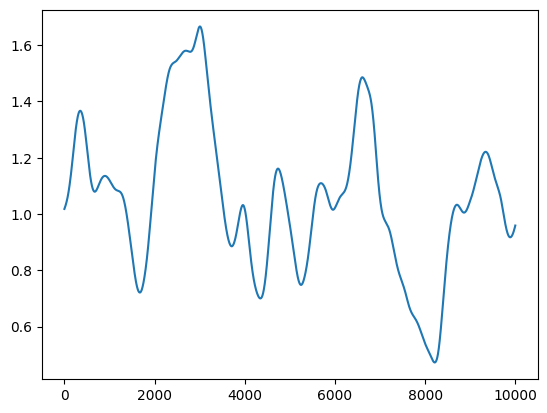

In [35]:
plt.plot(np.abs(results.outputs["o12"][30000:40000])**2)